# Set Up

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# make sure eager execution is on
tf.executing_eagerly()
# set random seeds for reproducability
np.random.seed(101)
tf.random.set_seed(101)

keras = tf.keras
l = keras.layers

# Data

In [5]:
# load and preprocess mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Scaling these values to a range of 0 to 1 before feeding them to the neural network model. 
# Remember to preprocess the training set and the testing in the same way.
x_train = x_train / 255.0
x_test = x_test / 255.0
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


# Model

In [6]:
# hyperparameters
NUM_EPOCHS = 15
NUM_CLASSES = 10
BATCH_SIZE = 64
INPUT_SHAPE = (784,)

LAYER_UNITS = (1000, 1000, 500, 200, NUM_CLASSES)

PRUNE_PERCENTILES = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

## Create

In [7]:
def create_model(weights=None):
  """
  Creates a dense model and initialises all its layers with weights
  if provided.

  Args:
      weights (list of numpy arrays, optional): pretrained weights for initializing layers.
  Returns:
      model(tf.keras.Model): model create with parameters
  """

  tf.keras.backend.clear_session()
  
  model = tf.keras.Sequential([
  l.Flatten(input_shape=(28, 28)),
  # Transforms the images from a 2D array to a 1D array.
  # It unstacks rows of pixels in the image and lines them up. 
  # This layer has no parameters to learn. It only reformats the data.
  l.Dense(units=1000, activation='relu'),
  l.Dense(units=1000, activation='relu'),
  l.Dense(units=500, activation='relu'),
  l.Dense(units=200, activation='relu'),
  l.Dense(units=10, activation='softmax') # Returns a logits array with length of 10
  ])

  if weights:
    model.set_weights(weights)

  model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # measures how accurate the model is during training. Goal is to minimize this function.
  optimizer='adam',
  metrics=['accuracy'])
  return model

In [8]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              785000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 2,388,710
Trainable params: 2,388,710
Non-trainable params: 0
______________________________________________

## Train

In [9]:
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test))

Epoch 1/15
938/938 [==============================] - 7s 7ms/step - loss: 1.5961 - accuracy: 0.8654 - val_loss: 1.5576 - val_accuracy: 0.9031
Epoch 2/15
938/938 [==============================] - 7s 7ms/step - loss: 1.5821 - accuracy: 0.8789 - val_loss: 1.5720 - val_accuracy: 0.8890
Epoch 3/15
938/938 [==============================] - 6s 7ms/step - loss: 1.6054 - accuracy: 0.8557 - val_loss: 1.5859 - val_accuracy: 0.8750
Epoch 4/15
938/938 [==============================] - 6s 7ms/step - loss: 1.6379 - accuracy: 0.8232 - val_loss: 1.6302 - val_accuracy: 0.8308
Epoch 5/15
938/938 [==============================] - 6s 7ms/step - loss: 1.6417 - accuracy: 0.8194 - val_loss: 1.6440 - val_accuracy: 0.8170
Epoch 6/15
938/938 [==============================] - 6s 7ms/step - loss: 1.6650 - accuracy: 0.7961 - val_loss: 1.6513 - val_accuracy: 0.8098
Epoch 7/15
938/938 [==============================] - 6s 7ms/step - loss: 1.6520 - accuracy: 0.8091 - val_loss: 1.6576 - val_accuracy: 0.8034
Epoch 

## Evaluate

In [10]:
# evaluate the model
model = create_model()
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 2.30188250541687
Test accuracy: 0.10119999945163727


# Pruning

In [21]:
def prune_and_evaluate_model(weights_to_prune,
                             pruning_type,
                             percentile,
                             device='gpu'):
    """
    Prunes the model according to the pruning_type(weight/unit) and evaluates
    model performance on the mnist test set

    Args:
        weights_to_prune (list of numpy arrays): pretrained weights to prune
        pruning_type (string): 'weight' or 'unit'
        percentile (int): percentage of weights/neurons to zero/remove
        device (str, optional): Device to run calculations on

    Returns:
        test accuracy of the pruned model

    Raises:
        NotImplementedError: pruning_type is something other than 'weight' or
                             'unit'
    """
    if device == 'gpu':
        device = '/gpu:0'
    else:
        device = '/cpu:0'

    if pruning_type == 'weight':
        pruned_weights = weight_pruning(weights_to_prune, percentile)
    if pruning_type == 'unit':
        pruned_weights = unit_pruning(weights_to_prune, percentile)
        #layer_units = new_layer_units
      
    model = create_model()
    model.set_weights(pruned_weights)
    
    with tf.device(device):
        t1 = time.time()
        _, test_acc = model.evaluate(x_test, y_test, verbose=0, batch_size=8)
        t2 = time.time()
        time_taken = t2-t1

    print(f"Test accuracy of the model after {pruning_type} pruning with" +
          f" {percentile}% sparsity is {test_acc:.2f}" +
          f". Time taken {time_taken:.2f} seconds")

    return test_acc, time_taken

## Weight

In [17]:
def weight_pruning(layer_weights, percentile):
    """Prune weights by magnitude and set to zero the smallest k%

    Args:
        layer_weights (list of numpy arrays): layer weights of pretrained model
        percentile (int): percentage of weight to prune

    Returns:
        pruned weights after weight pruning
    """
    pruned_weights = []

    # layer_weights[:-1] is used as we shouldn't prune the last layer
    for layer, weights in enumerate(layer_weights[:-1]):
        absolute_weights = np.abs(deepcopy(weights))
        # get the top k percentile weights
        thresh = np.percentile(absolute_weights, percentile)
        mask = absolute_weights < thresh
        # zero the weights whose values are less than the threshold value
        weights[mask] = 0
        pruned_weights.append(weights)

    pruned_weights.append(layer_weights[-1])
    return pruned_weights

## Unit

In [33]:
"""
Unit Pruning: 
  Input 'layer_weights' is a list of weights and bias matrices for each layer. 5 layers --> 5 weight matrices, 5 bias matrices. All bias matrices set to 0 by default.  
  Filtered weight matrices out of input and pruned, except last layer. All bias matrices were set to zeros. 
  New weights and bias matrices appended to pruned_weights. 
  Set inactive columns and rows to 0 but cannot delete because set_weights expects full architecture. 
"""


def unit_pruning(layer_weights, percentile):
    """Prune columns(neurons) of weight matrix according to their L2-norm and
       and delete the smallest k%
    Args:
        layer_weights (list of numpy arrays): layer weights of pretrained model
        percentile (int): percentage of weight to prune

    Returns:
        pruned weights after unit pruning
      
    """
    pruned_weights = []
    # as we remove neurons the number of units in each layer change, hence we
    # need to keep track of modified layer units
    layer_units = []
   
    # We have to remember the active neurons(rows) corresponding to the non-zero
    # columns of the prev layer.
    active_rows = None

    ##filtering out weight matrices from the bias matrices 
    new_weights_to_prune = []
    for layer, weights in enumerate(layer_weights[:-2]):
      if layer%2== 0: 
        new_weights_to_prune.append(layer_weights[layer]) 
   
    for layer, weights in enumerate(new_weights_to_prune):

        # only use the active rows(neurons) which correspond to nonzero
            # columns of prev layer
        if active_rows is not None:
          for i in range(len(active_rows)):
            if not active_rows[i]:
              weights[i] = weights[i]*0.0
            

        column_norms = np.linalg.norm(weights, ord=2, axis=0)
        # get the top k percentile col norms
        thresh = np.percentile(column_norms, percentile)
        active_columns = column_norms >= thresh
        for i in range(len(active_columns)):
            if not active_columns[i]:
              weights[:,i] = weights[:,i]*0.0

        active_rows = active_columns
        layer_units.append(len(active_columns))
        pruned_weights.append(weights)

        #append bias matrices to pruned_weights
        biases = np.zeros(weights.shape[1])
        pruned_weights.append(biases)



     # only use the active rows(neurons) which correpond to nonzero
    # columns of prev layer. Note there is no pruning done for the last layer
    for i in range(len(active_rows)):
      if not active_rows[i]: 
        layer_weights[-2][i] = layer_weights[-2][i]*0.0

    layer_units.append(len(active_rows))
    pruned_weights.append(layer_weights[-2])
    pruned_weights.append(np.zeros(10))
    
    return pruned_weights #, layer_units TO ADD
               

# Plots

## Weight Pruning vs Unit Pruning

In [34]:
for pruning_type in ['unit']: #TODO both
    pruning_accuracies = []
    print(f'\nRunning {pruning_type} pruning on GPU\n')
    for percentile in PRUNE_PERCENTILES:
        test_acc = prune_and_evaluate_model(
            weights_to_prune=model.get_weights(),
            pruning_type=pruning_type, 
            percentile=percentile,
            device='gpu')

for pruning_type in ['weight']: #TODO both
    pruning_accuracies = []
    print(f'\nRunning {pruning_type} pruning on GPU\n')
    for percentile in PRUNE_PERCENTILES:
        test_acc = prune_and_evaluate_model(
            weights_to_prune=model.get_weights(),
            pruning_type=pruning_type, 
            percentile=percentile,
            device='gpu')


#         pruning_accuracies.append(test_acc)
#     plt.plot(PRUNE_PERCENTILES, pruning_accuracies, label=pruning_type)

# plt.xlabel('Sparsity (%)')
# plt.ylabel('Model Accuracies')
# plt.legend(loc='lower left')
# plt.title(f'Weight Pruning vs Unit Pruning')

#TODO add time taken plot
# plt.plot(PRUNE_PERCENTILES, pruning_times,
#                  label=pruning_type + ' pruned dense ' + 'matrix')

# plt.xlabel('Sparsity (%)')
# plt.ylabel('Time taken (seconds)')
# plt.legend(loc='upper right')
# plt.title(f'Benchmarking Dense operations with Weight/Unit pruning')


Running unit pruning on GPU

Test accuracy of the model after unit pruning with 0% sparsity is 0.10. Time taken 2.45 seconds
Test accuracy of the model after unit pruning with 25% sparsity is 0.11. Time taken 2.45 seconds
Test accuracy of the model after unit pruning with 50% sparsity is 0.11. Time taken 2.45 seconds
Test accuracy of the model after unit pruning with 60% sparsity is 0.11. Time taken 2.45 seconds
Test accuracy of the model after unit pruning with 70% sparsity is 0.07. Time taken 2.46 seconds
Test accuracy of the model after unit pruning with 80% sparsity is 0.11. Time taken 2.44 seconds
Test accuracy of the model after unit pruning with 90% sparsity is 0.10. Time taken 2.47 seconds
Test accuracy of the model after unit pruning with 95% sparsity is 0.06. Time taken 2.45 seconds
Test accuracy of the model after unit pruning with 97% sparsity is 0.09. Time taken 2.44 seconds
Test accuracy of the model after unit pruning with 99% sparsity is 0.10. Time taken 2.60 seconds



## Weight Pruning Plots

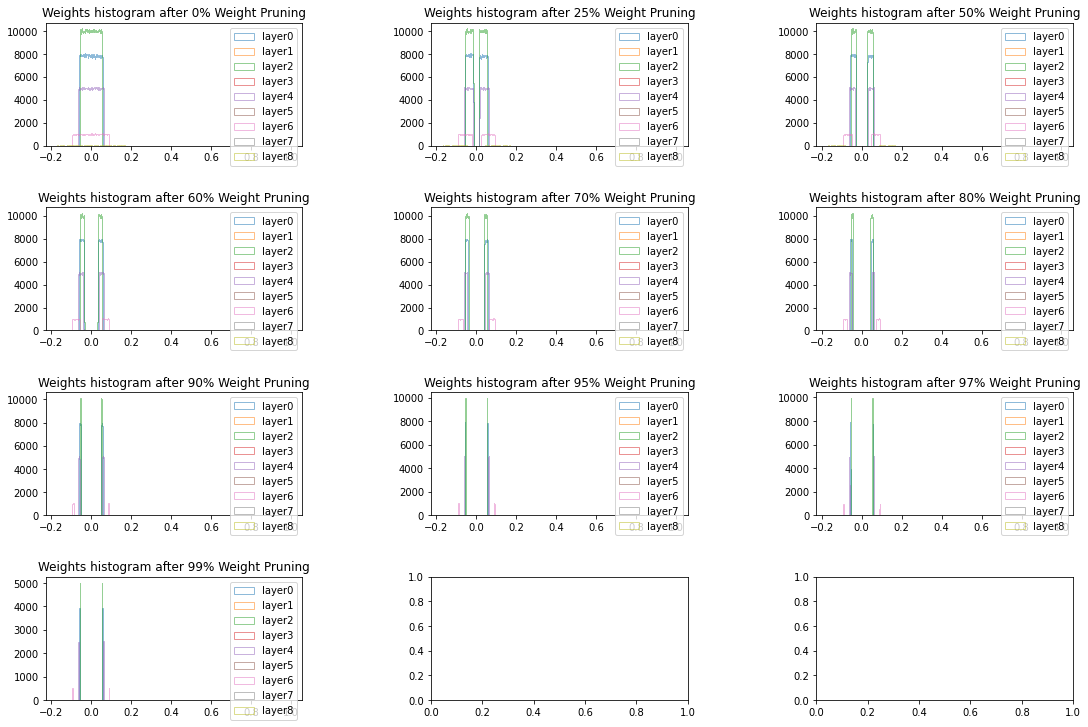

In [27]:
def plot_weight_histogram(weights, ax):
    # weights[:-1] as we dont want to analyse the 
    # last unpruned layer
    for i, weight in enumerate(weights[:-1]):
        weight = weight.reshape(-1)
        # we will only plot the non zero values
        weight = weight[weight != 0]
        ax.hist(weight, bins=100, histtype='step',
                label='layer' + str(i), alpha=0.5)
    ax.legend(loc='upper right')


def plot_column_norm_histogram(weights, ax):
    # weights[:-1] as we dont want to analyse the 
    # last unpruned layer
    for i, weight in enumerate(weights[:-1]):
        column_norms = np.linalg.norm(weight, ord=2, axis=0)
        ax.hist(column_norms, bins=100, histtype='step',
                label='layer' + str(i), alpha=0.5)
    ax.legend(loc='upper right')

    
fig, axes = plt.subplots(4, 3, figsize=(15,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights = weight_pruning(deepcopy(model.get_weights()), percentile)
    plot_weight_histogram(pruned_weights, ax)
    ax.set_title(f'Weights histogram after {percentile}% Weight Pruning')

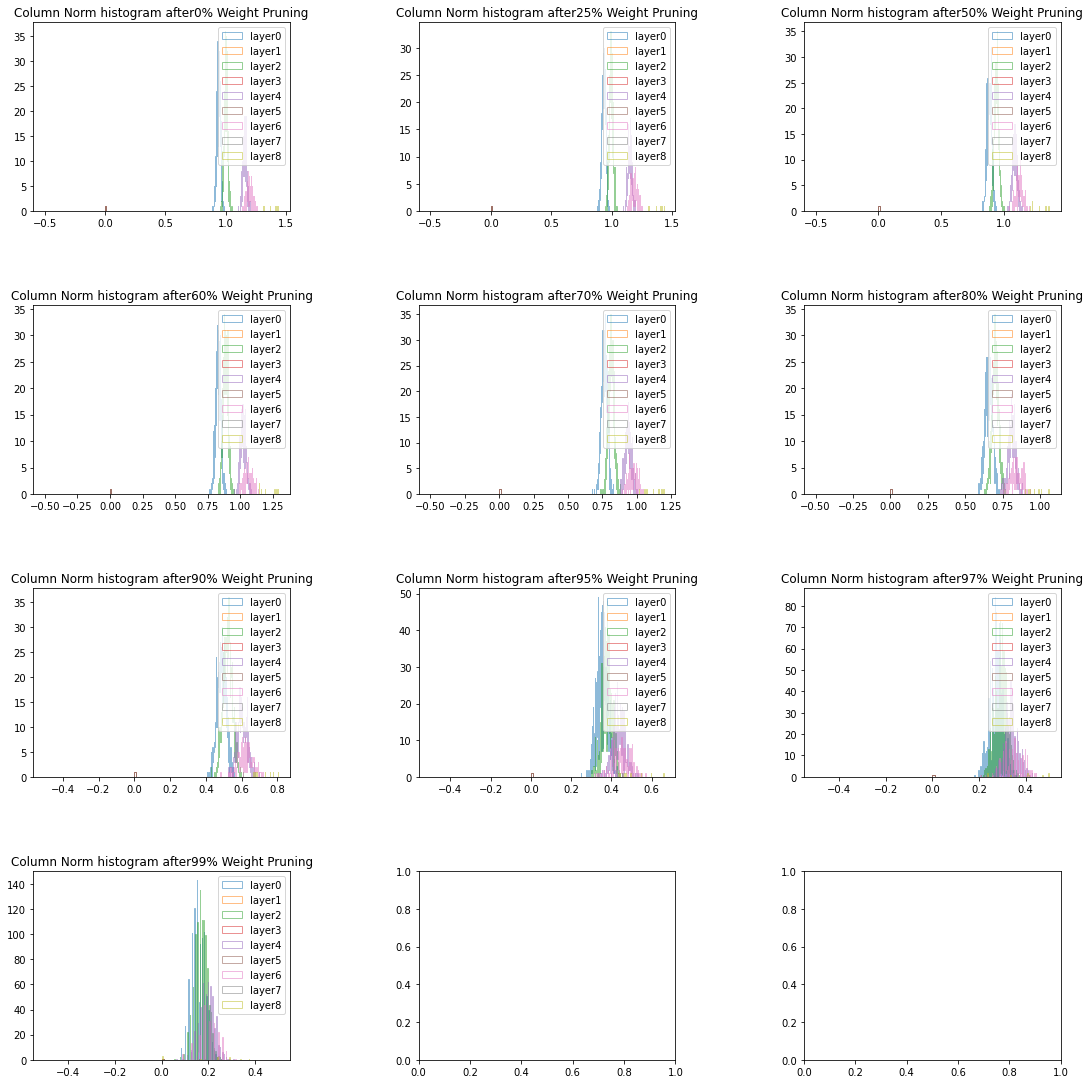

In [28]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights = weight_pruning(deepcopy(model.get_weights()), percentile)
    plot_column_norm_histogram(pruned_weights, ax)
    ax.set_title(f'Column Norm histogram after{percentile}% Weight Pruning')

## Unit Pruning Plots

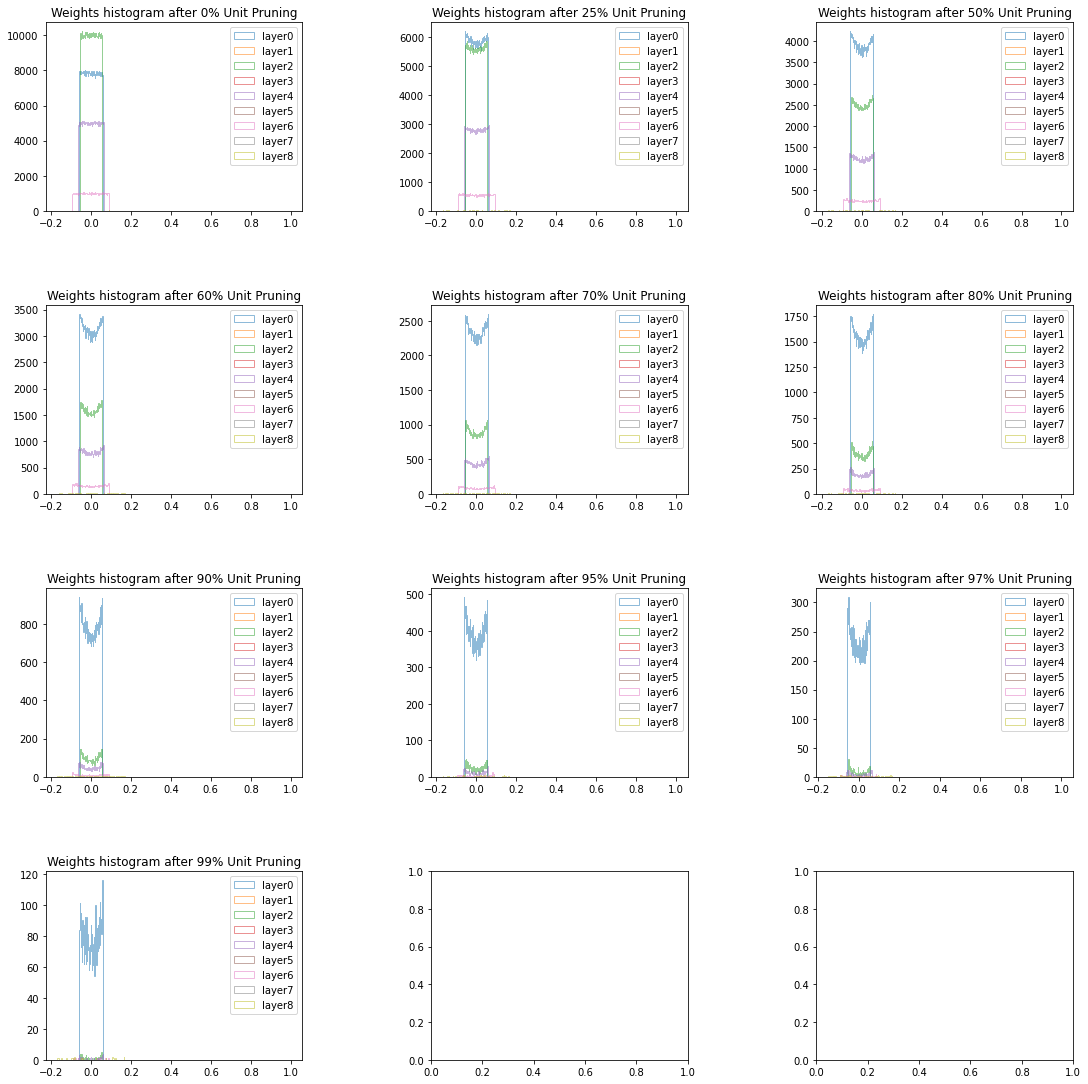

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights = unit_pruning(deepcopy(model.get_weights()), percentile)
    plot_weight_histogram(pruned_weights, ax)
    ax.set_title(f'Weights histogram after {percentile}% Unit Pruning')


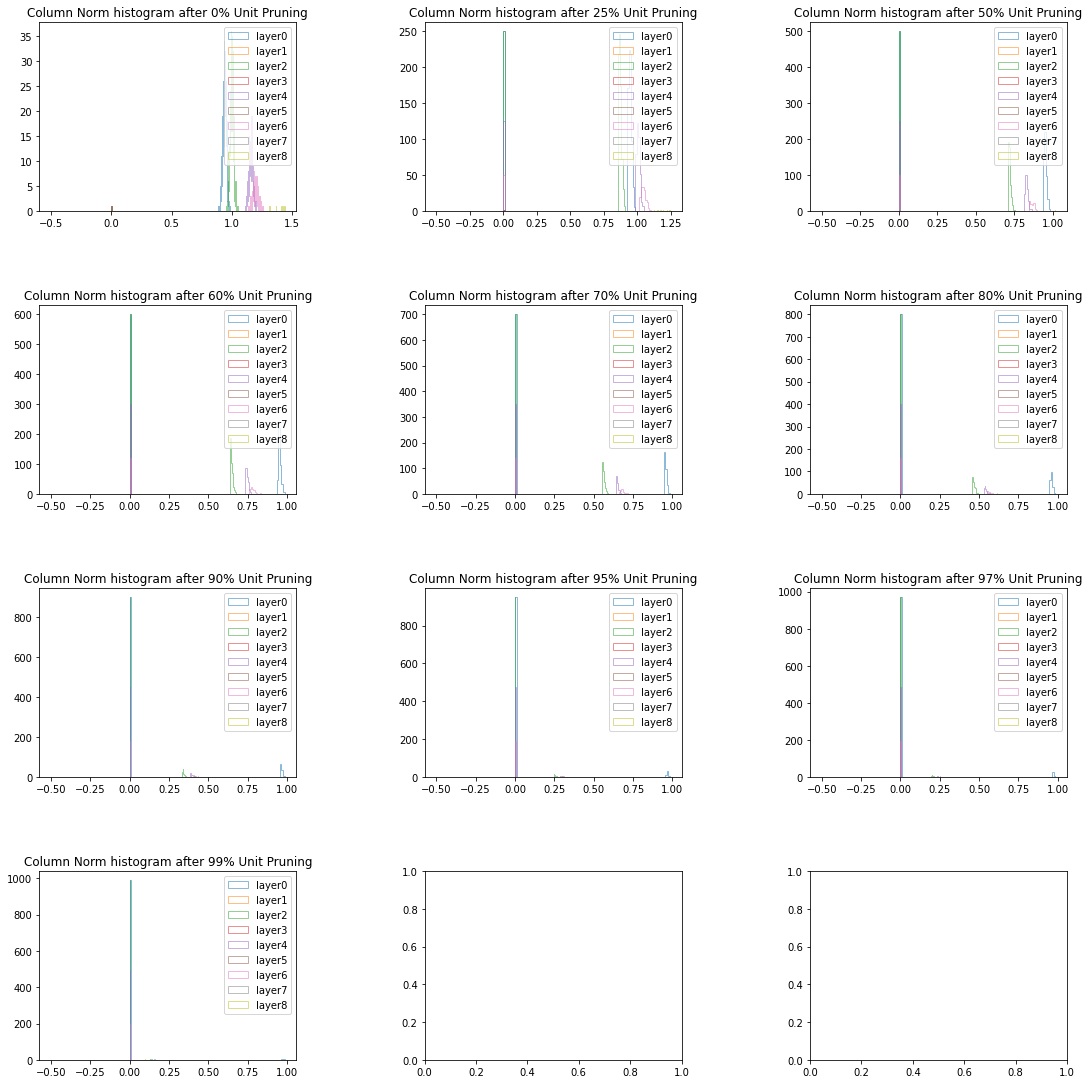

In [31]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.ravel()[:10]

for ax, percentile in zip(axes, PRUNE_PERCENTILES):
    pruned_weights = unit_pruning(deepcopy(model.get_weights()), percentile)
    plot_column_norm_histogram(pruned_weights, ax)
    ax.set_title(f'Column Norm histogram after {percentile}% Unit Pruning')

# Conclusions

- From the plots, we can clearly see *Weight pruning* outperforms *Unit pruning* when we are measuring model accuracy.

- In case of *Weight pruning* the performance only starts decreasing after 90% sparsity, while in the case of *Unit pruning* the decline happens much earlier starting from 70% sparsity.

- At 99% sparsity, both methods predict at random(accuracy of 10 % in case of *Unit pruning* and 15% for *Weight pruning*)

- One of the reasons why the model's performance is not hurt even after 80% weight pruning could be that most of the values in the trained model are around 0(as seen from the plot). Perhaps we can postulate that only 10 - 15 % of the weights contribute to the task.

- The major benefit of *Unit pruning* over *Weight pruning* is the computational speed. Since we are removing neurons(deleting the smallest k% according to their L2-norm) in *Unit pruning*, the model parameters reduce drastically and this enhances speed.

- Sparse linear algebra operations enhance the speed of the model in case of *Weight pruning* but only when the sparsity is significant(above 80% in this task).

-tf sparse_to_dense_matmul is not optimised for big batch_size on gpu"

https://github.com/tensorflow/tensorflow/issues/12475
